In [4]:
import pandas as pd
from dotenv import load_dotenv
from openai import OpenAI
from anthropic import Anthropic
from jumpstart.src.consts import *

load_dotenv(override=True)
openai = OpenAI()
anthropic = Anthropic() 

In [2]:
import jumpstart.src.oracle
from jumpstart.src.oracle import generate_oracle_csv

# Regenerate the oracle CSV with automatic MTG data download and caching
print("🔄 Generating oracle CSV with automatic data download...")
generate_oracle_csv('pauper_cube_example_oracle.txt', 'output/oracle_output.csv')
print("✅ Oracle CSV generation complete!")

🔄 Generating oracle CSV with automatic data download...
Using cached cards data: .build/cards.csv
Oracle CSV generated: output/oracle_output.csv
✅ Oracle CSV generation complete!


In [5]:
# Load the data files
oracle_df = pd.read_csv('output/oracle_output.csv')
print(f"Loaded {len(oracle_df)} cards from oracle_df")
print(f"Columns available: {list(oracle_df.columns)}")
oracle_df.head()

Loaded 450 cards from oracle_df
Columns available: ['name', 'CMC', 'Type', 'Color', 'Color Category', 'Oracle Text', 'tags', 'MTGO ID', 'Power', 'Toughness']


,name,CMC,Type,Color,Color Category,Oracle Text,tags,MTGO ID,Power,Toughness
0,Boros Elite,1,Creature — Human Soldier,W,White,Battalion — Whenever this creature and at leas...,NaN,NaN,1.0,1.0
1,Deftblade Elite,1,Creature — Human Soldier,W,White,"Provoke (Whenever this creature attacks, you m...",NaN,NaN,1.0,1.0
2,Doomed Traveler,1,Creature — Human Soldier,W,White,"When this creature dies, create a 1/1 white Sp...",NaN,NaN,1.0,1.0
3,Elite Vanguard,1,Creature — Human Soldier,W,White,NaN,NaN,NaN,2.0,1.0
4,Faerie Guidemother,1,Sorcery — Adventure,W,White,Target creature gets +2/+1 and gains flying un...,NaN,NaN,NaN,NaN


# Generate Themes

In [17]:
# Basic extraction with guild theme support

# Get a summary report
from jumpstart.src.theme_extraction.extractor import ThemeExtractor
from jumpstart.src.theme_extraction.utils import generate_theme_code


extractor = ThemeExtractor(oracle_df)
# Now includes guild themes by default!
themes = extractor.extract_themes(min_cards_per_theme=10, include_guilds=True)
print(extractor.generate_theme_summary(themes))

generate_theme_code(themes, "NEW_THEMES")

# Extracted Themes Summary

## Tribal Themes (4)
- **Black Tribals** (B): Zombie tribal with synergistic effects and creature bonuses
- **Blue Tribals** (U): Wizard tribal with synergistic effects and creature bonuses
- **Red Tribals** (R): Warrior tribal with synergistic effects and creature bonuses
- **White Tribals** (W): Soldier tribal with synergistic effects and creature bonuses

## Equipment Themes (3)
- **Black Equipment** (B): Equipment strategy with equipment gameplan
- **Red Equipment** (R): Equipment strategy with equipment gameplan
- **White Equipment** (W): Equipment strategy with equipment gameplan

## Aggro Themes (12)
- **Black Aggro** (B): Aggro strategy with aggro gameplan
- **Black Fast** (B): Fast aggressive deck with efficient low-cost threats
- **Blue Fast** (U): Fast aggressive deck with efficient low-cost threats
- **Boros Aggro** (R + W): Boros guild synergies with aggro gameplan
- **Green Aggro** (G): Aggro strategy with aggro gameplan
- **Green Fast** (G): F

'NEW_THEMES_WITH_GUILDS = {\n    \'White Tribals\': {\n        \'colors\': [\'W\'],\n        \'strategy\': \'Soldier tribal with synergistic effects and creature bonuses\',\n        \'keywords\': [\'tribal\', \'soldier\', \'creature\', \'enters\', \'lord\', \'gets +\', \'anthem\', \'pump\', \'attack\', \'vigilance\', \'first strike\'],\n        \'archetype\': Archetype.TRIBAL,\n        \'scorer\': create_tribal_scorer,\n        \'core_card_count\': 4\n    },\n    \'White Equipment\': {\n        \'colors\': [\'W\'],\n        \'strategy\': \'Equipment strategy with equipment gameplan\',\n        \'keywords\': [\'artifact\', \'equip\', \'sword\', \'improvise\', \'construct\', \'servo\', \'attach\', \'weapon\', \'blade\', \'equipment\', \'armor\', \'metalcraft\', \'equipped\'],\n        \'archetype\': Archetype.EQUIPMENT,\n        \'scorer\': create_equipment_scorer,\n        \'core_card_count\': 3\n    },\n    \'White Aggro\': {\n        \'colors\': [\'W\'],\n        \'strategy\': \'Aggro

In [8]:
# Let's examine the color distribution to see why no guild themes are being generated
print("Color distribution in oracle data:")
color_counts = oracle_df['Color'].value_counts()
print(color_counts.head(20))

print("\nUnique color values:")
unique_colors = oracle_df['Color'].unique()
print(f"Total unique color values: {len(unique_colors)}")
for color in unique_colors:
    if pd.notna(color) and str(color).strip():
        print(f"  '{color}'")

print("\nLooking for multicolor cards:")
multicolor_cards = oracle_df[oracle_df['Color'].str.len() > 1]
print(f"Cards with color length > 1: {len(multicolor_cards)}")

if len(multicolor_cards) > 0:
    print("\nSample multicolor cards:")
    print(multicolor_cards[['name', 'Color', 'Type']].head(10))

Color distribution in oracle data:
Color
W     70
U     67
B     67
R     67
G     67
BU     4
BR     4
GR     4
GW     4
BW     4
RU     4
BG     4
GU     4
UW     3
RW     3
Name: count, dtype: int64

Unique color values:
Total unique color values: 16
  'W'
  'U'
  'B'
  'R'
  'G'
  'UW'
  'BU'
  'BR'
  'GR'
  'GW'
  'BW'
  'RU'
  'BG'
  'RW'
  'GU'

Looking for multicolor cards:
Cards with color length > 1: 38

Sample multicolor cards:
                     name Color                      Type
362        Lyev Skyknight    UW   Creature — Human Knight
363          Silver Drake    UW          Creature — Drake
364          Cavern Harpy    BU    Creature — Harpy Beast
365     Soul Manipulation    BU                   Instant
366        Dinrova Horror    BU         Creature — Horror
367          Body Dropper    BR  Creature — Devil Warrior
368      Fireblade Artist    BR   Creature — Human Shaman
369            Blightning    BR                   Sorcery
370  Goblin Anarchomancer    GR  Cr

In [9]:
# The issue is that the minimum card requirement is too high for guild themes
# Let's try with a lower threshold to see guild themes
print("Testing theme extraction with lower minimum cards per theme...")

extractor = ThemeExtractor(oracle_df)
themes_low_threshold = extractor.extract_themes(min_cards_per_theme=3)  # Lower threshold
print(f"Found {len(themes_low_threshold)} themes with threshold of 3")

guild_themes = {name: theme for name, theme in themes_low_threshold.items() 
                if len(theme['colors']) == 2}
print(f"\nFound {len(guild_themes)} guild themes:")
for name in sorted(guild_themes.keys()):
    theme = guild_themes[name]
    colors = ' + '.join([c.split('.')[-1] for c in theme['colors']])
    print(f"  {name} ({colors})")

if guild_themes:
    print(f"\nGenerating code for guild themes:")
    generate_theme_code(guild_themes, "GUILD_THEMES")

Testing theme extraction with lower minimum cards per theme...
Found 75 themes with threshold of 3

Found 0 guild themes:


In [10]:
# Let's debug the color combination detection
extractor = ThemeExtractor(oracle_df)

# Test the color parsing directly
print("Testing color parsing on sample multicolor cards:")
sample_colors = ['UW', 'BU', 'BR', 'GR', 'GW', 'BW']
for color_str in sample_colors:
    parsed = extractor._parse_colors(color_str)
    print(f"  '{color_str}' -> {parsed}")

print("\nTesting _get_color_combinations with very low threshold:")
combinations = extractor._get_color_combinations(min_cards=1)
print(f"Found {len(combinations)} color combinations:")
for colors, name_prefix in combinations:
    print(f"  {colors} -> '{name_prefix}'")

print("\nChecking if multicolor cards are being filtered correctly:")
# Test filtering for a specific guild
test_colors = ['U', 'W']
filtered_df = extractor._filter_by_colors(test_colors)
print(f"Cards matching {test_colors}: {len(filtered_df)}")
if len(filtered_df) > 0:
    print("Sample filtered cards:")
    print(filtered_df[['name', 'Color']].head())

Testing color parsing on sample multicolor cards:
  'UW' -> ['U', 'W']
  'BU' -> ['B', 'U']
  'BR' -> ['B', 'R']
  'GR' -> ['G', 'R']
  'GW' -> ['G', 'W']
  'BW' -> ['B', 'W']

Testing _get_color_combinations with very low threshold:
Found 15 color combinations:
  ['W'] -> 'White'
  ['U'] -> 'Blue'
  ['B'] -> 'Black'
  ['R'] -> 'Red'
  ['G'] -> 'Green'
  ['U', 'W'] -> 'Azorius'
  ['B', 'U'] -> 'Dimir'
  ['B', 'R'] -> 'Rakdos'
  ['G', 'R'] -> 'Gruul'
  ['G', 'W'] -> 'Selesnya'
  ['B', 'W'] -> 'Orzhov'
  ['R', 'U'] -> 'Izzet'
  ['B', 'G'] -> 'Golgari'
  ['R', 'W'] -> 'Boros'
  ['G', 'U'] -> 'Simic'

Checking if multicolor cards are being filtered correctly:
Cards matching ['U', 'W']: 3
Sample filtered cards:
                 name Color
362    Lyev Skyknight    UW
363      Silver Drake    UW
391  Judge's Familiar    UW


In [11]:
# Let's debug the keyword analysis for guild themes
print("Debugging keyword analysis for guild combinations...")

# Test a specific guild - Azorius (U/W)
test_guild_colors = ['U', 'W']
filtered_guild_df = extractor._filter_by_colors(test_guild_colors)
print(f"\nAzorius cards ({len(filtered_guild_df)}):")
print(filtered_guild_df[['name', 'Color', 'Oracle Text']].head())

# Test keyword analysis for this guild
print(f"\nTesting keyword themes for Azorius:")
keyword_themes = extractor._analyze_keyword_themes(test_guild_colors)
print(f"Found {len(keyword_themes)} keyword themes for Azorius")

if keyword_themes:
    for i, theme in enumerate(keyword_themes):
        print(f"  Theme {i}: {theme['archetype']} with {theme['core_card_count']} core cards")

# Test tribal analysis
print(f"\nTesting tribal themes for Azorius:")
tribal_themes = extractor._analyze_tribal_themes(test_guild_colors)
print(f"Found {len(tribal_themes)} tribal themes for Azorius")

# Check what happens if we lower the minimum threshold in the keyword analysis
print(f"\nChecking keyword counts manually for Azorius cards:")
from jumpstart.src.theme_extraction.keywords import CONTROL_KEYWORDS, TEMPO_KEYWORDS

control_count = extractor._count_keyword_cards(filtered_guild_df, CONTROL_KEYWORDS)
tempo_count = extractor._count_keyword_cards(filtered_guild_df, TEMPO_KEYWORDS)
print(f"  Control keywords: {control_count} cards")
print(f"  Tempo keywords: {tempo_count} cards")
print(f"  Current threshold in keyword analysis: 10 cards minimum")

Debugging keyword analysis for guild combinations...

Azorius cards (3):
                 name Color                                        Oracle Text
362    Lyev Skyknight    UW  flying\nwhen this creature enters, detain targ...
363      Silver Drake    UW  flying\nwhen this creature enters, return a wh...
391  Judge's Familiar    UW  flying\nsacrifice this creature: counter targe...

Testing keyword themes for Azorius:
Found 0 keyword themes for Azorius

Testing tribal themes for Azorius:
Found 0 tribal themes for Azorius

Checking keyword counts manually for Azorius cards:
  Control keywords: 2 cards
  Tempo keywords: 2 cards
  Current threshold in keyword analysis: 10 cards minimum


In [13]:
# Create a modified version of the theme extractor that can handle guild themes
print("Creating guild themes with modified logic...")

def create_guild_themes(oracle_df):
    """Create guild themes with lower thresholds specifically for 2-color combinations."""
    extractor = ThemeExtractor(oracle_df)
    guild_themes = {}
    
    # Get all 2-color combinations with any number of cards
    color_combinations = extractor._get_color_combinations(min_cards=1)
    two_color_combinations = [(colors, name) for colors, name in color_combinations if len(colors) == 2]
    
    print(f"Found {len(two_color_combinations)} guild combinations")
    
    for colors, guild_name in two_color_combinations:
        filtered_df = extractor._filter_by_colors(colors)
        card_count = len(filtered_df)
        
        if card_count >= 3:  # Lower threshold for guilds
            print(f"  Creating theme for {guild_name} ({card_count} cards)")
            
            # Determine best archetype based on available cards and guild identity
            guild_archetypes = {
                'Azorius': 'Control',      # U/W - Control
                'Dimir': 'Control',        # U/B - Control/Mill  
                'Rakdos': 'Aggro',         # B/R - Aggro/Burn
                'Gruul': 'Aggro',          # R/G - Aggro/Ramp
                'Selesnya': 'Midrange',    # G/W - Tokens/Midrange
                'Orzhov': 'Midrange',      # B/W - Lifegain/Midrange
                'Izzet': 'Tempo',          # U/R - Spells/Tempo
                'Golgari': 'Midrange',     # B/G - Graveyard/Midrange
                'Boros': 'Aggro',         # R/W - Aggro/Equipment
                'Simic': 'Ramp'            # G/U - Ramp/Value
            }
            
            archetype_name = guild_archetypes.get(guild_name, 'Midrange')
            
            # Convert archetype name to enum
            from jumpstart.src.enums import Archetype
            archetype_map = {
                'Aggro': Archetype.AGGRO,
                'Control': Archetype.CONTROL, 
                'Midrange': Archetype.MIDRANGE,
                'Tempo': Archetype.TEMPO,
                'Ramp': Archetype.RAMP
            }
            archetype = archetype_map[archetype_name]
            
            # Create guild-specific keywords based on the guild identity
            guild_keywords = {
                'Azorius': ['flying', 'counter', 'detain', 'control', 'flying creatures'],
                'Dimir': ['mill', 'graveyard', 'card draw', 'control', 'surveillance'], 
                'Rakdos': ['haste', 'aggressive', 'damage', 'sacrifice', 'unleash'],
                'Gruul': ['trample', 'haste', 'power matters', 'bloodrush', 'ramp'],
                'Selesnya': ['tokens', 'populate', 'convoke', 'creatures matter', 'anthem'],
                'Orzhov': ['lifegain', 'extort', 'removal', 'aristocrats', 'afterlife'],
                'Izzet': ['instant', 'sorcery', 'spells matter', 'card draw', 'overload'],
                'Golgari': ['graveyard', 'scavenge', 'dredge', 'sacrifice', 'undergrowth'],
                'Boros': ['equipment', 'battalion', 'mentor', 'aggressive', 'combat'],
                'Simic': ['card draw', 'ramp', 'evolve', 'adapt', '+1/+1 counters']
            }
            
            keywords = guild_keywords.get(guild_name, ['multicolor', 'synergy'])
            
            # Get appropriate scorer for archetype
            from jumpstart.src.scorer import (
                create_default_scorer, create_aggressive_scorer, create_control_scorer
            )
            
            scorer_map = {
                Archetype.AGGRO: create_aggressive_scorer,
                Archetype.CONTROL: create_control_scorer,
                Archetype.MIDRANGE: create_default_scorer,
                Archetype.TEMPO: create_aggressive_scorer,
                Archetype.RAMP: create_default_scorer
            }
            scorer = scorer_map.get(archetype, create_default_scorer)
            
            # Create the theme
            theme = {
                'colors': [extractor._color_to_enum_value(c) for c in colors],
                'strategy': f'{guild_name} guild synergies with {archetype_name.lower()} gameplan',
                'keywords': keywords,
                'archetype': archetype,
                'scorer': scorer,
                'core_card_count': min(3, max(2, card_count // 2))
            }
            
            theme_name = f"{guild_name} {archetype_name}"
            guild_themes[theme_name] = theme
    
    return guild_themes

# Generate guild themes
guild_themes = create_guild_themes(oracle_df)
print(f"\nGenerated {len(guild_themes)} guild themes:")
for name, theme in guild_themes.items():
    colors = ' + '.join([c.split('.')[-1] for c in theme['colors']])
    print(f"  {name} ({colors}): {theme['strategy']}")

Creating guild themes with modified logic...
Found 10 guild combinations
  Creating theme for Azorius (3 cards)
  Creating theme for Dimir (4 cards)
  Creating theme for Rakdos (4 cards)
  Creating theme for Gruul (4 cards)
  Creating theme for Selesnya (4 cards)
  Creating theme for Orzhov (4 cards)
  Creating theme for Izzet (4 cards)
  Creating theme for Golgari (4 cards)
  Creating theme for Boros (3 cards)
  Creating theme for Simic (4 cards)

Generated 10 guild themes:
  Azorius Control (U + W): Azorius guild synergies with control gameplan
  Dimir Control (B + U): Dimir guild synergies with control gameplan
  Rakdos Aggro (B + R): Rakdos guild synergies with aggro gameplan
  Gruul Aggro (G + R): Gruul guild synergies with aggro gameplan
  Selesnya Midrange (G + W): Selesnya guild synergies with midrange gameplan
  Orzhov Midrange (B + W): Orzhov guild synergies with midrange gameplan
  Izzet Tempo (R + U): Izzet guild synergies with tempo gameplan
  Golgari Midrange (B + G): Gol

In [14]:
# Generate the code for guild themes
print("Generating Python code for guild themes:")
print("="*60)

guild_code = generate_theme_code(guild_themes, "GUILD_THEMES")
print(guild_code)

Generating Python code for guild themes:
GUILD_THEMES = {
    'Azorius Control': {
        'colors': ['U', 'W'],
        'strategy': 'Azorius guild synergies with control gameplan',
        'keywords': ['flying', 'counter', 'detain', 'control', 'flying creatures'],
        'archetype': Archetype.CONTROL,
        'scorer': create_control_scorer,
        'core_card_count': 2
    },
    'Dimir Control': {
        'colors': ['B', 'U'],
        'strategy': 'Dimir guild synergies with control gameplan',
        'keywords': ['mill', 'graveyard', 'card draw', 'control', 'surveillance'],
        'archetype': Archetype.CONTROL,
        'scorer': create_control_scorer,
        'core_card_count': 2
    },
    'Rakdos Aggro': {
        'colors': ['B', 'R'],
        'strategy': 'Rakdos guild synergies with aggro gameplan',
        'keywords': ['haste', 'aggressive', 'damage', 'sacrifice', 'unleash'],
        'archetype': Archetype.AGGRO,
        'scorer': create_aggressive_scorer,
        'core_card

In [15]:
# Now let's create a comprehensive theme extraction that includes both regular and guild themes
print("Creating comprehensive theme extraction (regular + guild themes)...")

def extract_all_themes_including_guilds(oracle_df, min_cards_per_theme=10):
    """Extract all themes including guild themes with appropriate thresholds."""
    
    # Get regular themes with the standard threshold
    extractor = ThemeExtractor(oracle_df)
    regular_themes = extractor.extract_themes(min_cards_per_theme)
    
    # Get guild themes with lower threshold
    guild_themes = create_guild_themes(oracle_df)
    
    # Combine all themes
    all_themes = {}
    all_themes.update(regular_themes)
    all_themes.update(guild_themes)
    
    return all_themes

# Extract all themes
all_themes = extract_all_themes_including_guilds(oracle_df, min_cards_per_theme=10)

print(f"Total themes found: {len(all_themes)}")
print(f"  Regular themes: {len(all_themes) - len(guild_themes)}")
print(f"  Guild themes: {len(guild_themes)}")

# Show guild themes specifically
print("\nGuild themes found:")
for name, theme in guild_themes.items():
    colors = ' + '.join([c.split('.')[-1] for c in theme['colors']])
    print(f"  ✓ {name} ({colors})")

# Generate comprehensive code
print(f"\nGenerating comprehensive theme code:")
comprehensive_code = generate_theme_code(all_themes, "ALL_THEMES_WITH_GUILDS")
print("Code generated successfully! (Output truncated due to length)")

# Show just the guild portion for verification
print(f"\nGuild themes code preview:")
print("="*40)
print(guild_code[:500] + "..." if len(guild_code) > 500 else guild_code)

Creating comprehensive theme extraction (regular + guild themes)...
Found 10 guild combinations
  Creating theme for Azorius (3 cards)
  Creating theme for Dimir (4 cards)
  Creating theme for Rakdos (4 cards)
  Creating theme for Gruul (4 cards)
  Creating theme for Selesnya (4 cards)
  Creating theme for Orzhov (4 cards)
  Creating theme for Izzet (4 cards)
  Creating theme for Golgari (4 cards)
  Creating theme for Boros (3 cards)
  Creating theme for Simic (4 cards)
Total themes found: 85
  Regular themes: 75
  Guild themes: 10

Guild themes found:
  ✓ Azorius Control (U + W)
  ✓ Dimir Control (B + U)
  ✓ Rakdos Aggro (B + R)
  ✓ Gruul Aggro (G + R)
  ✓ Selesnya Midrange (G + W)
  ✓ Orzhov Midrange (B + W)
  ✓ Izzet Tempo (R + U)
  ✓ Golgari Midrange (B + G)
  ✓ Boros Aggro (R + W)
  ✓ Simic Ramp (G + U)

Generating comprehensive theme code:
Code generated successfully! (Output truncated due to length)

Guild themes code preview:
GUILD_THEMES = {
    'Azorius Control': {
        'c

In [16]:
# Test the improved theme extractor with built-in guild support
print("Testing the improved ThemeExtractor with guild support...")

# Reload the module to get the updated version
import importlib
import jumpstart.src.theme_extraction.extractor
importlib.reload(jumpstart.src.theme_extraction.extractor)
from jumpstart.src.theme_extraction.extractor import ThemeExtractor

# Create new extractor and test
extractor_improved = ThemeExtractor(oracle_df)
themes_with_guilds = extractor_improved.extract_themes(min_cards_per_theme=10, include_guilds=True)

print(f"Improved extraction found {len(themes_with_guilds)} themes")

# Count guild themes specifically
guild_themes_built_in = {name: theme for name, theme in themes_with_guilds.items() 
                        if len(theme['colors']) == 2}
print(f"Built-in guild themes: {len(guild_themes_built_in)}")

for name in sorted(guild_themes_built_in.keys()):
    theme = guild_themes_built_in[name]
    colors = ' + '.join([c.split('.')[-1] for c in theme['colors']])
    print(f"  ✓ {name} ({colors})")

# Test without guilds
themes_without_guilds = extractor_improved.extract_themes(min_cards_per_theme=10, include_guilds=False)
print(f"\nWithout guilds: {len(themes_without_guilds)} themes")
print(f"With guilds: {len(themes_with_guilds)} themes")
print(f"Guild themes added: {len(themes_with_guilds) - len(themes_without_guilds)}")

# Generate updated theme code
print(f"\nGenerating updated theme code with built-in guild support:")
updated_code = generate_theme_code(themes_with_guilds, "THEMES_WITH_GUILD_SUPPORT")
print("✅ Updated code generated successfully!")

Testing the improved ThemeExtractor with guild support...
Improved extraction found 85 themes
Built-in guild themes: 10
  ✓ Azorius Control (U + W)
  ✓ Boros Aggro (R + W)
  ✓ Dimir Control (B + U)
  ✓ Golgari Midrange (B + G)
  ✓ Gruul Aggro (G + R)
  ✓ Izzet Tempo (R + U)
  ✓ Orzhov Midrange (B + W)
  ✓ Rakdos Aggro (B + R)
  ✓ Selesnya Midrange (G + W)
  ✓ Simic Ramp (G + U)

Without guilds: 75 themes
With guilds: 85 themes
Guild themes added: 10

Generating updated theme code with built-in guild support:
✅ Updated code generated successfully!


In [18]:
# Simple test - just check if the updated module loads
print("🔧 Testing updated DeckBuilder...")

try:
    # Test importing the updated module
    from jumpstart.src.construct.builder import DeckBuilder
    print("✅ DeckBuilder import successful")
    
    # Check the constructor signature
    import inspect
    sig = inspect.signature(DeckBuilder.__init__)
    print(f"✅ Constructor parameters: {list(sig.parameters.keys())}")
    
    # Quick test with just oracle_df
    builder = DeckBuilder(oracle_df)
    print(f"✅ DeckBuilder created with default themes: {len(builder.themes)} themes")
    
except Exception as e:
    print(f"❌ Error: {e}")
    import traceback
    traceback.print_exc()

🔧 Testing updated DeckBuilder...
✅ DeckBuilder import successful
✅ Constructor parameters: ['self', 'oracle_df', 'themes', 'constraints']
✅ DeckBuilder created with default themes: 30 themes


# Deck Construction
Now let's test the deck construction function to build actual jumpstart decks from our themes.

In [ ]:
# Test the refactored deck construction function

# Build all jumpstart decks using the new refactored version
from jumpstart.src.construct import construct_jumpstart_decks, print_detailed_deck_analysis, CardConstraints, analyze_deck_composition

# Create constraints with custom target deck size and non-land limits
constraints = CardConstraints(
    target_deck_size=13,
    max_lands_dual=1,
    max_lands_mono=1,
    total_non_land=12,  # All 12 cards should be non-lands
    min_creatures=2,  # Set minimum to 4 for testing
    max_creatures=9
)

print("🚀 Starting deck construction with refactored algorithm...")
deck_dataframes = construct_jumpstart_decks(oracle_df, constraints=constraints, themes=ALL_THEMES)

# Generate analysis first, then print detailed analysis
analysis = analyze_deck_composition(deck_dataframes)
print_detailed_deck_analysis(deck_dataframes, analysis, constraints)

🚀 Starting deck construction with refactored algorithm...
🏗️ CONSTRUCTING JUMPSTART DECKS

🔒 Phase 0: Core card reservation
Ensuring each theme gets its defining cards before general competition...

🎯 White Soldiers: Reserving core cards
  ✅ Boros Elite               |   5.3 pts | Creature — Human Sol...
  ✅ Miner's Guidewing         |   5.3 pts | Creature — Bird
  ✅ Topan Freeblade           |   4.8 pts | Creature — Human Sol...
  ✅ Ainok Bond-Kin            |   4.3 pts | Creature — Dog Soldi...
  📦 Reserved 4 core cards

🎯 White Equipment: Reserving core cards
  ✅ Ancestral Blade           |  11.8 pts | Artifact — Equipment
  ✅ Vulshok Morningstar       |  11.8 pts | Artifact — Equipment
  ✅ Mandibular Kite           |  11.2 pts | Artifact — Equipment
  ✅ Greatsword of Tyr         |  11.2 pts | Artifact — Equipment
  ✅ Flayer Husk               |  11.2 pts | Artifact — Equipment
  📦 Reserved 5 core cards

🎯 White Angels: Reserving core cards
  ✅ Combat Professor          |   6.8 pts 

In [6]:
from jumpstart.src.export import export_cube_to_csv


export_cube_to_csv(deck_dataframes, 'output/jumpstart_decks.csv', oracle_df)

Exporting jumpstart cube to output/jumpstart_decks.csv...
Adding 60 unassigned cards...
✅ Successfully exported 450 cards to output/jumpstart_decks.csv

📊 Export Summary:
Total cards: 450
Assigned cards: 390
Unassigned cards: 60
Number of decks: 30

Deck breakdown:
  Red Burn: 13 cards
  Black Control: 13 cards
  White Vanguard: 13 cards
  Golgari Graveyard Value: 13 cards
  Blue Flying: 13 cards
  Red Goblins: 13 cards
  Green Stompy: 13 cards
  Green Ramp: 13 cards
  Dimir Mill: 13 cards
  Orzhov Lifegain Value: 13 cards
  Unassigned: 60 cards
  ... and 20 more decks


'output/jumpstart_decks.csv'

In [7]:
# Import validation functions and run card uniqueness validation
from jumpstart.src.validation import validate_card_uniqueness, validate_deck_constraints, validate_jumpstart_cube, display_validation_summary

# Run the validation
# validation_result = validate_card_uniqueness(deck_dataframes)
validate_jumpstart_cube(deck_dataframes, oracle_df, ALL_THEMES, constraints)

🎯 COMPREHENSIVE JUMPSTART CUBE VALIDATION
🔍 VALIDATING CARD UNIQUENESS
📊 VALIDATION RESULTS:
Total cards across all decks: 390
Unique cards used: 390
Duplicate cards found: 0

✅ VALIDATION PASSED!
All 390 cards are used exactly once.
🔍 VALIDATING DECK CONSTRAINTS
📊 CONSTRAINT VALIDATION RESULTS:
Valid decks: 30/30
Constraint violations: 0

✅ ALL CONSTRAINTS SATISFIED!

📈 CARD DISTRIBUTION ANALYSIS
📊 OVERALL STATISTICS:
Total cards available: 450
Total cards used: 390
Cards unused: 60
Usage rate: 86.7%

🎨 USAGE BY COLOR:
  White    :  64/ 70 cards ( 91.4%)
  Blue     :  63/ 67 cards ( 94.0%)
  Black    :  54/ 67 cards ( 80.6%)
  Red      :  61/ 67 cards ( 91.0%)
  Green    :  63/ 67 cards ( 94.0%)
  Colorless:  51/ 74 cards ( 68.9%)

🎯 DECK COMPLETENESS:
Complete decks (13 cards): 30
Incomplete decks: 0

📋 UNUSED CARDS ANALYSIS:
Unused creatures: 11
Unused lands: 23
Unused spells: 26

Sample unused cards:
  • Pegasus Guardian (Instant — Adventure) - W
  • Settle Beyond Reality (Sorcery)

{'overall_valid': True,
 'uniqueness': {'valid': True,
  'total_cards': 390,
  'unique_cards': 390,
  'duplicates': {},
  'duplicate_count': 0,
  'extra_instances': 0},
 'constraints': {'valid': True,
  'valid_decks': 30,
  'total_decks': 30,
  'violations': []},
 'distribution': {'total_available': 450,
  'total_used': 390,
  'unused_count': 60,
  'usage_rate': 0.8666666666666667,
  'color_stats': {'W': {'used': 64,
    'available': 70,
    'rate': 91.42857142857143},
   'U': {'used': 63, 'available': 67, 'rate': 94.02985074626866},
   'B': {'used': 54, 'available': 67, 'rate': 80.59701492537313},
   'R': {'used': 61, 'available': 67, 'rate': 91.04477611940298},
   'G': {'used': 63, 'available': 67, 'rate': 94.02985074626866},
   'C': {'used': 51, 'available': 74, 'rate': 68.91891891891892}},
  'complete_decks': 30,
  'incomplete_decks': []}}

In [8]:
# Additional analysis using the imported validation functions
from jumpstart.src.validation import analyze_card_distribution

# Run the distribution analysis
distribution_analysis = analyze_card_distribution(deck_dataframes, oracle_df, constraints)


📈 CARD DISTRIBUTION ANALYSIS
📊 OVERALL STATISTICS:
Total cards available: 450
Total cards used: 390
Cards unused: 60
Usage rate: 86.7%

🎨 USAGE BY COLOR:
  White    :  64/ 70 cards ( 91.4%)
  Blue     :  63/ 67 cards ( 94.0%)
  Black    :  54/ 67 cards ( 80.6%)
  Red      :  61/ 67 cards ( 91.0%)
  Green    :  63/ 67 cards ( 94.0%)
  Colorless:  51/ 74 cards ( 68.9%)

🎯 DECK COMPLETENESS:
Complete decks (13 cards): 30
Incomplete decks: 0

📋 UNUSED CARDS ANALYSIS:
Unused creatures: 11
Unused lands: 23
Unused spells: 26

Sample unused cards:
  • Pegasus Guardian (Instant — Adventure) - W
  • Settle Beyond Reality (Sorcery) - W
  • Oblivion Ring (Enchantment) - W
  • Faith's Fetters (Enchantment — Aura) - W
  • Bubble Snare (Enchantment — Aura) - U
  • Unable to Scream (Enchantment — Aura) - U
  • Weakstone's Subjugation (Enchantment — Aura) - U
  • Witness Protection (Enchantment — Aura) - U
  • Carnophage (Creature — Zombie) - B
  • Carrion Feeder (Creature — Zombie) - B


In [9]:
# Compute metrics for all decks\n
from jumpstart.src.balance import compute_all_deck_metrics
metrics_df = compute_all_deck_metrics(deck_dataframes, ALL_THEMES)
metrics_df.set_index('theme', inplace=True)
metrics_df.head()


,avg_cmc,keyword_density,archetype_alignment,card_quality,synergy,deck_size,type_creature,type_human,type_soldier,type_bird,...,type_spider,type_thrull,type_imp,type_arcane,type_hag,type_leech,type_mutant,type_cartouche,type_dinosaur,type_turtle
theme,,,,,,,,,,,,,,,,,,,,,
White Soldiers,1.153846,0.571429,0.692308,1.692308,1.076923,13,0.290323,0.161290,0.258065,0.032258,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
White Equipment,1.923077,0.666667,0.269231,2.076923,4.769231,13,0.218750,0.125000,0.125000,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
White Angels,3.769231,0.666667,0.461538,3.461538,0.846154,13,0.272727,0.090909,0.090909,0.060606,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
White Vanguard,1.384615,0.200000,0.615385,1.461538,2.461538,13,0.250000,0.125000,0.062500,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Blue Flying,2.846154,0.857143,1.000000,2.692308,1.923077,13,0.321429,NaN,NaN,0.142857,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


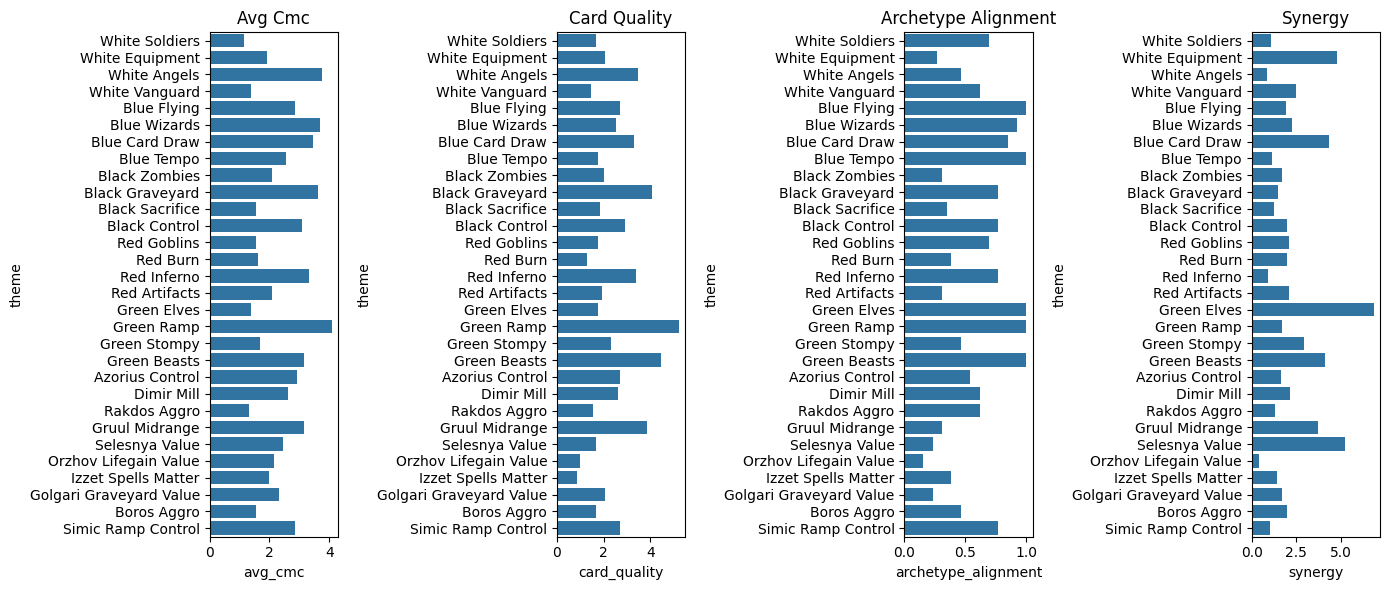

In [10]:
# Bar plots for key metrics
import matplotlib.pyplot as plt
import seaborn as sns
plt.figure(figsize=(14, 6))
for i, metric in enumerate(['avg_cmc', 'card_quality', 'archetype_alignment', 'synergy']):
    plt.subplot(1, 4, i+1)
    sns.barplot(y=metrics_df.index, x=metrics_df[metric], orient='h')
    plt.title(metric.replace('_', ' ').title())
    plt.tight_layout()
plt.show()

In [11]:
# Import plotly for interactive visualizations
import plotly.graph_objects as go

sample_themes = metrics_df.index[:]  # Show first 5 decks as example
radar_metrics = ['avg_cmc', 'card_quality', 'archetype_alignment', 'synergy', 'keyword_density']
fig = go.Figure()
for theme in sample_themes:
    values = metrics_df.loc[theme, radar_metrics].values.tolist()
    fig.add_trace(go.Scatterpolar(
        r=values + [values[0]],
        theta=radar_metrics + [radar_metrics[0]],
        fill='toself',
        name=theme
    ))
fig.update_layout(
    polar=dict(radialaxis=dict(visible=True)),
    showlegend=True,
    title='Deck Balance Radar Chart (Sample)'
)
fig.show()

# CMC Curve Analysis
Let's visualize the Converted Mana Cost (CMC) curves for each deck to understand their mana distribution and speed.

In [12]:
# Calculate CMC curves for all decks
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from collections import Counter

def calculate_cmc_curve(deck_df):
    """Calculate the CMC distribution for a deck."""
    # Only count non-land cards for CMC curve
    non_lands = deck_df[deck_df['Type'].str.contains('Land', na=False) == False]
    cmc_counts = Counter(non_lands['CMC'])
    
    # Create a full range from 0 to max CMC
    max_cmc = max(cmc_counts.keys()) if cmc_counts else 0
    cmc_curve = [cmc_counts.get(i, 0) for i in range(max_cmc + 1)]
    
    return cmc_curve, non_lands

# Calculate CMC curves for all decks
cmc_data = {}
deck_stats = {}

for theme_name, deck_df in deck_dataframes.items():
    cmc_curve, non_lands = calculate_cmc_curve(deck_df)
    cmc_data[theme_name] = cmc_curve
    deck_stats[theme_name] = {
        'avg_cmc': non_lands['CMC'].mean() if len(non_lands) > 0 else 0,
        'total_cards': len(deck_df),
        'non_lands': len(non_lands),
        'lands': len(deck_df) - len(non_lands)
    }

print("CMC curve data calculated for all decks!")
print(f"Sample stats for first deck ({list(deck_stats.keys())[0]}):")
first_deck = list(deck_stats.keys())[0]
print(f"  Average CMC: {deck_stats[first_deck]['avg_cmc']:.2f}")
print(f"  Total cards: {deck_stats[first_deck]['total_cards']}")
print(f"  Non-land cards: {deck_stats[first_deck]['non_lands']}")
print(f"  Lands: {deck_stats[first_deck]['lands']}")

CMC curve data calculated for all decks!
Sample stats for first deck (White Soldiers):
  Average CMC: 1.25
  Total cards: 13
  Non-land cards: 12
  Lands: 1


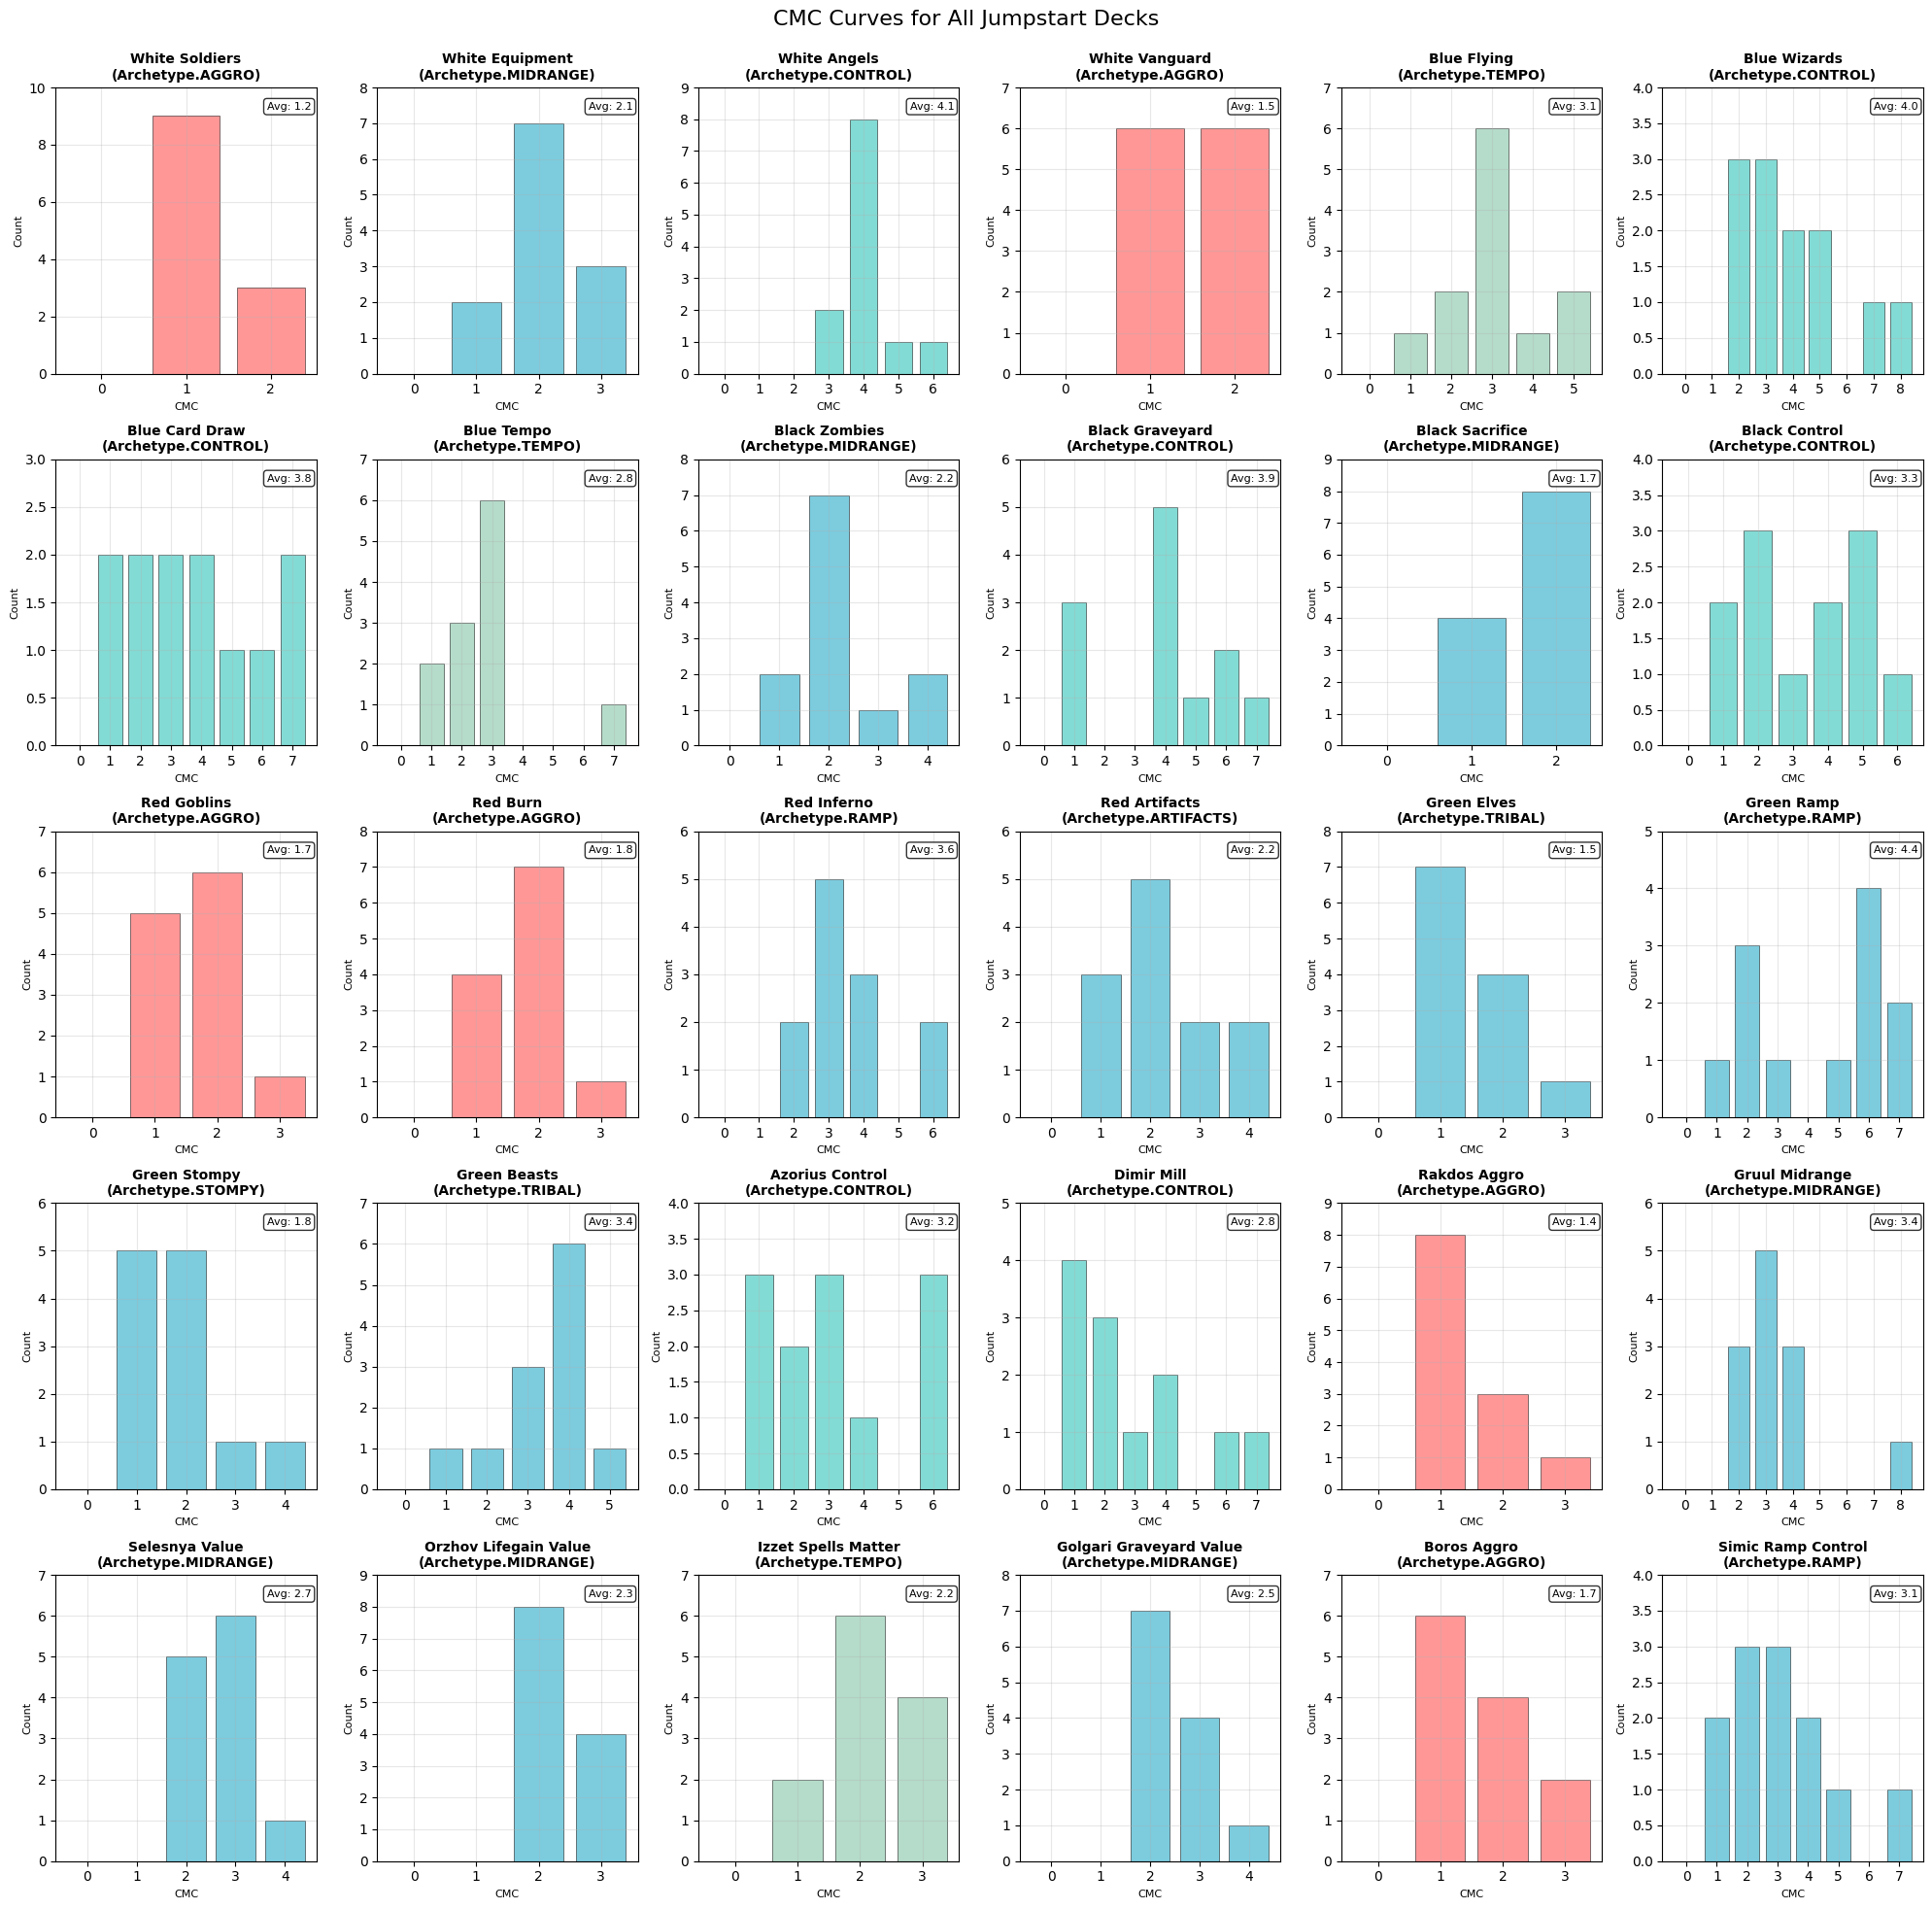

✅ CMC curves plotted for all 30 decks!
Color legend:
  Aggro: #FF6B6B
  Control: #4ECDC4
  Midrange: #45B7D1
  Tempo: #96CEB4
  Combo: #FFEAA7


In [13]:
# Create a large grid plot showing CMC curves for all decks
plt.style.use('default')
num_decks = len(deck_dataframes)
cols = 6  # 6 columns
rows = (num_decks + cols - 1) // cols  # Calculate needed rows

fig, axes = plt.subplots(rows, cols, figsize=(20, 4 * rows))
fig.suptitle('CMC Curves for All Jumpstart Decks', fontsize=16, y=0.98)

# Flatten axes for easy iteration
if rows == 1:
    axes = [axes] if cols == 1 else axes
else:
    axes = axes.flatten()

# Color scheme for different archetypes
archetype_colors = {
    'Aggro': '#FF6B6B',
    'Control': '#4ECDC4', 
    'Midrange': '#45B7D1',
    'Tempo': '#96CEB4',
    'Combo': '#FFEAA7'
}

for i, (theme_name, deck_df) in enumerate(deck_dataframes.items()):
    ax = axes[i]
    
    # Get CMC curve and deck info
    cmc_curve, non_lands = calculate_cmc_curve(deck_df)
    
    # Determine archetype for coloring
    archetype = 'Midrange'  # Default
    if theme_name in ALL_THEMES:
        archetype = ALL_THEMES[theme_name].get('archetype', 'Midrange')
    
    color = archetype_colors.get(archetype, '#45B7D1')
    
    # Plot the CMC curve
    x_values = list(range(len(cmc_curve)))
    ax.bar(x_values, cmc_curve, color=color, alpha=0.7, edgecolor='black', linewidth=0.5)
    
    # Customize each subplot
    ax.set_title(f'{theme_name}\n({archetype})', fontsize=10, fontweight='bold')
    ax.set_xlabel('CMC', fontsize=8)
    ax.set_ylabel('Count', fontsize=8)
    ax.set_xticks(x_values)
    ax.grid(True, alpha=0.3)
    
    # Add average CMC as text
    avg_cmc = non_lands['CMC'].mean() if len(non_lands) > 0 else 0
    ax.text(0.98, 0.95, f'Avg: {avg_cmc:.1f}', transform=ax.transAxes, 
            ha='right', va='top', fontsize=8, 
            bbox=dict(boxstyle='round,pad=0.3', facecolor='white', alpha=0.8))
    
    # Set consistent y-axis limits
    ax.set_ylim(0, max(max(cmc_curve), 1) + 1)

# Hide empty subplots
for i in range(num_decks, len(axes)):
    axes[i].set_visible(False)

plt.tight_layout()
plt.subplots_adjust(top=0.94)
plt.show()

print(f"✅ CMC curves plotted for all {num_decks} decks!")
print("Color legend:")
for archetype, color in archetype_colors.items():
    print(f"  {archetype}: {color}")

In [14]:
# Summary statistics and comparison plots
print("📊 CMC CURVE SUMMARY STATISTICS")
print("="*50)

# Create a DataFrame with CMC statistics
cmc_summary = []
for theme_name, stats in deck_stats.items():
    archetype = ALL_THEMES.get(theme_name, {}).get('archetype', 'Midrange')
    # Convert enum to string for DataFrame compatibility
    if hasattr(archetype, 'value'):
        archetype = archetype.value
    
    cmc_summary.append({
        'Theme': theme_name,
        'Archetype': archetype,
        'Avg_CMC': stats['avg_cmc'],
        'Total_Cards': stats['total_cards'],
        'Non_Lands': stats['non_lands'],
        'Lands': stats['lands']
    })

cmc_summary_df = pd.DataFrame(cmc_summary)
cmc_summary_df = cmc_summary_df.sort_values('Avg_CMC')

print("Top 5 Fastest Decks (Lowest Average CMC):")
print(cmc_summary_df.head()[['Theme', 'Archetype', 'Avg_CMC']].to_string(index=False))

print("\nTop 5 Slowest Decks (Highest Average CMC):")
print(cmc_summary_df.tail()[['Theme', 'Archetype', 'Avg_CMC']].to_string(index=False))

print(f"\nOverall Statistics:")
print(f"Average CMC across all decks: {cmc_summary_df['Avg_CMC'].mean():.2f}")
print(f"CMC Standard Deviation: {cmc_summary_df['Avg_CMC'].std():.2f}")
print(f"Fastest deck: {cmc_summary_df.iloc[0]['Theme']} ({cmc_summary_df.iloc[0]['Avg_CMC']:.2f})")
print(f"Slowest deck: {cmc_summary_df.iloc[-1]['Theme']} ({cmc_summary_df.iloc[-1]['Avg_CMC']:.2f})")

📊 CMC CURVE SUMMARY STATISTICS
Top 5 Fastest Decks (Lowest Average CMC):
         Theme Archetype  Avg_CMC
White Soldiers     Aggro 1.250000
  Rakdos Aggro     Aggro 1.416667
White Vanguard     Aggro 1.500000
   Green Elves    Tribal 1.500000
   Boros Aggro     Aggro 1.666667

Top 5 Slowest Decks (Highest Average CMC):
          Theme Archetype  Avg_CMC
 Blue Card Draw   Control 3.750000
Black Graveyard   Control 3.916667
   Blue Wizards   Control 4.000000
   White Angels   Control 4.083333
     Green Ramp      Ramp 4.416667

Overall Statistics:
Average CMC across all decks: 2.64
CMC Standard Deviation: 0.92
Fastest deck: White Soldiers (1.25)
Slowest deck: Green Ramp (4.42)


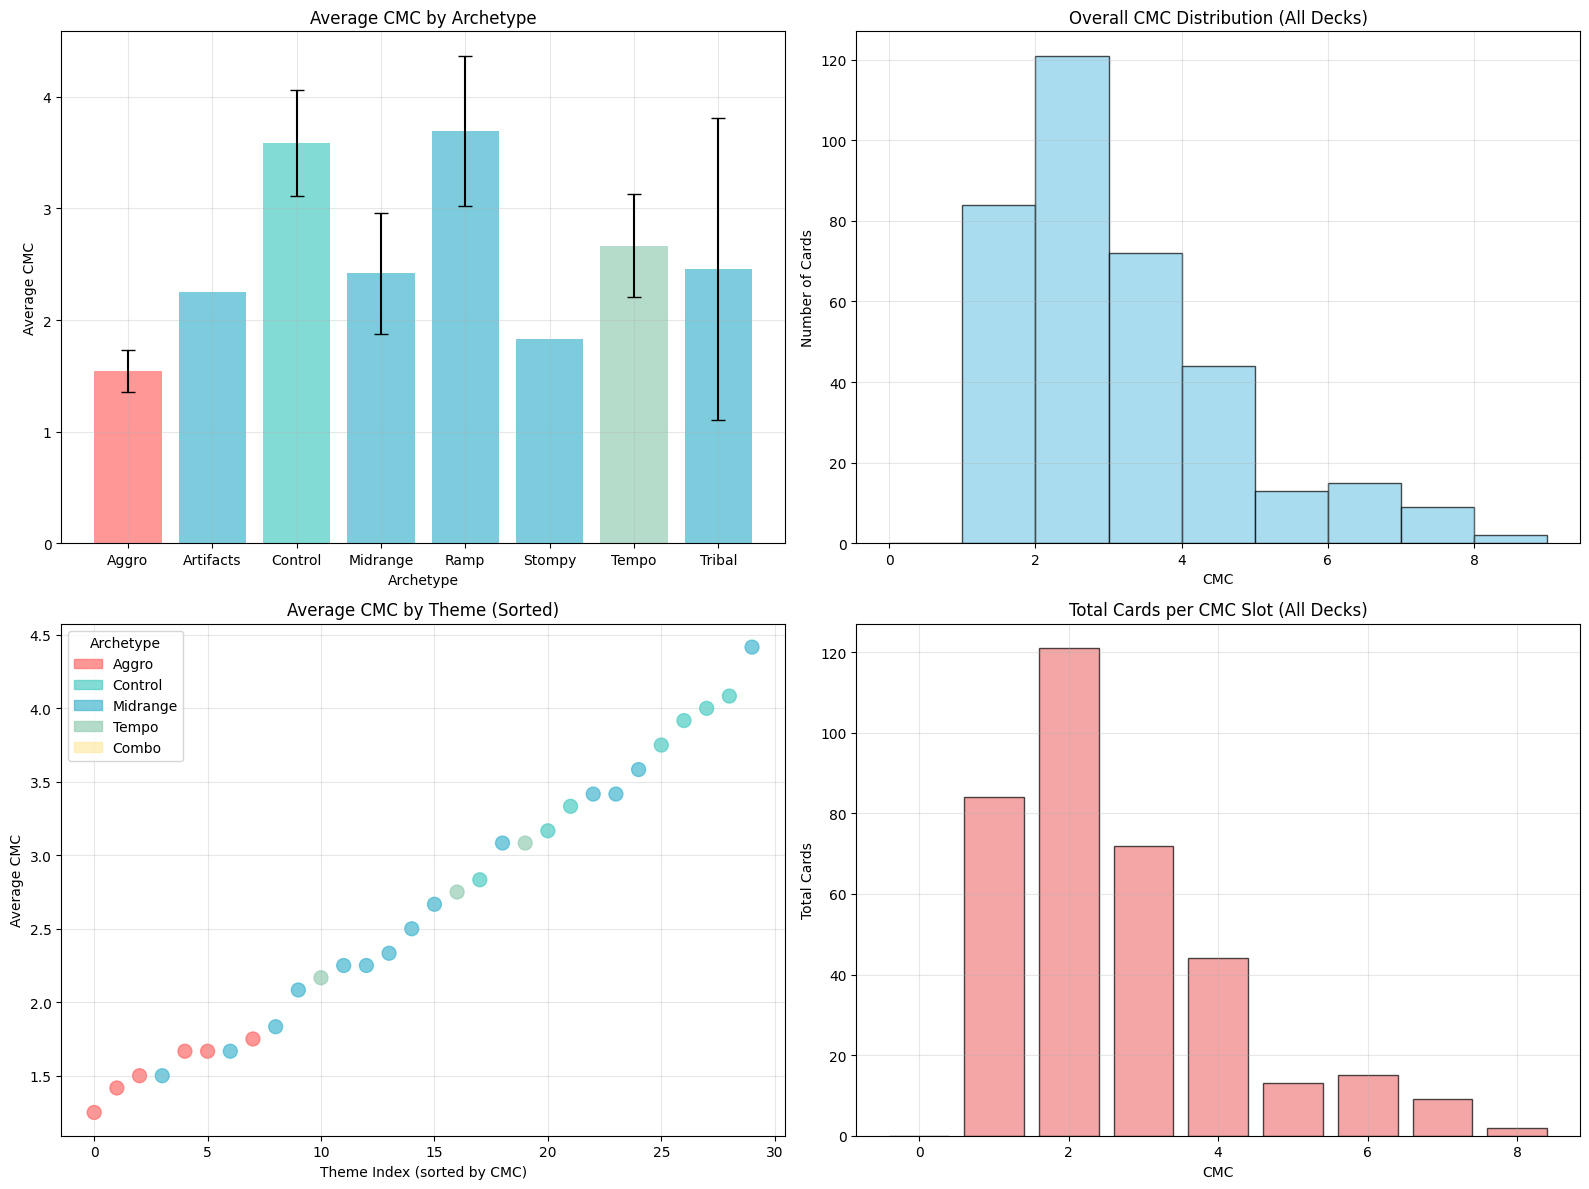

✅ CMC analysis complete! The visualizations show:
  📈 Individual deck curves with archetype coloring
  📊 Statistical summaries and comparisons
  🎯 Archetype-based CMC patterns
  📋 Overall cube CMC distribution


In [15]:
# Archetype comparison plots
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(16, 12))

# Convert archetype enums to strings for plotting compatibility
cmc_summary_df_plot = cmc_summary_df.copy()
cmc_summary_df_plot['Archetype'] = cmc_summary_df_plot['Archetype'].apply(
    lambda x: x.value if hasattr(x, 'value') else str(x)
)

# 1. Average CMC by Archetype
archetype_cmc = cmc_summary_df_plot.groupby('Archetype')['Avg_CMC'].agg(['mean', 'std', 'count'])
ax1.bar(archetype_cmc.index, archetype_cmc['mean'], 
        yerr=archetype_cmc['std'], capsize=5, alpha=0.7,
        color=[archetype_colors.get(arch, '#45B7D1') for arch in archetype_cmc.index])
ax1.set_title('Average CMC by Archetype')
ax1.set_ylabel('Average CMC')
ax1.set_xlabel('Archetype')
ax1.grid(True, alpha=0.3)

# 2. CMC Distribution (all decks combined)
all_cmcs = []
for theme_name, deck_df in deck_dataframes.items():
    non_lands = deck_df[deck_df['Type'].str.contains('Land', na=False) == False]
    all_cmcs.extend(non_lands['CMC'].tolist())

ax2.hist(all_cmcs, bins=range(max(all_cmcs) + 2), alpha=0.7, color='skyblue', edgecolor='black')
ax2.set_title('Overall CMC Distribution (All Decks)')
ax2.set_xlabel('CMC')
ax2.set_ylabel('Number of Cards')
ax2.grid(True, alpha=0.3)

# 3. Average CMC scatter plot by theme
colors = []
for theme in cmc_summary_df_plot['Theme']:
    archetype = ALL_THEMES.get(theme, {}).get('archetype', 'Midrange')
    # Convert enum to string for color lookup
    if hasattr(archetype, 'value'):
        archetype = archetype.value
    colors.append(archetype_colors.get(archetype, '#45B7D1'))

ax3.scatter(range(len(cmc_summary_df_plot)), cmc_summary_df_plot['Avg_CMC'], 
           c=colors, alpha=0.7, s=100)
ax3.set_title('Average CMC by Theme (Sorted)')
ax3.set_xlabel('Theme Index (sorted by CMC)')
ax3.set_ylabel('Average CMC')
ax3.grid(True, alpha=0.3)

# Add archetype legend
handles = [plt.Rectangle((0,0),1,1, color=color, alpha=0.7) 
           for archetype, color in archetype_colors.items()]
labels = list(archetype_colors.keys())
ax3.legend(handles, labels, title='Archetype', loc='upper left')

# 4. Cards per CMC slot comparison
cmc_slots = {}
max_cmc = max(all_cmcs)
for cmc in range(max_cmc + 1):
    cmc_slots[cmc] = sum(1 for c in all_cmcs if c == cmc)

ax4.bar(cmc_slots.keys(), cmc_slots.values(), alpha=0.7, color='lightcoral', edgecolor='black')
ax4.set_title('Total Cards per CMC Slot (All Decks)')
ax4.set_xlabel('CMC')
ax4.set_ylabel('Total Cards')
ax4.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print("✅ CMC analysis complete! The visualizations show:")
print("  📈 Individual deck curves with archetype coloring")
print("  📊 Statistical summaries and comparisons")
print("  🎯 Archetype-based CMC patterns")
print("  📋 Overall cube CMC distribution")

# Comprehensive Deck Performance Analysis

Now let's analyze how well each deck will perform across multiple dimensions. This analysis will help identify the strongest and weakest decks, and suggest improvements.

## Performance Metrics We'll Analyze:
1. **Speed & Consistency** - How fast and reliable the deck is
2. **Card Quality** - Overall power level of individual cards
3. **Synergy Score** - How well cards work together
4. **Threat Density** - Proportion of impactful cards
5. **Interaction Quality** - Removal and answers available
6. **Mana Efficiency** - How well the deck uses its mana
7. **Late Game Power** - Performance in longer games
8. **Archetype Coherence** - How well the deck follows its intended strategy

In [16]:
def calculate_deck_performance_metrics(deck_df, theme_name, oracle_df):
    """
    Calculate comprehensive performance metrics for a single deck.
    """
    metrics = {}
    
    # Basic deck info
    non_lands = deck_df[deck_df['Type'].str.contains('Land', na=False) == False]
    creatures = deck_df[deck_df['Type'].str.contains('Creature', na=False)]
    
    # 1. Speed & Consistency Metrics
    avg_cmc = non_lands['CMC'].mean() if len(non_lands) > 0 else 0
    cmc_variance = non_lands['CMC'].var() if len(non_lands) > 1 else 0
    early_game_cards = len(non_lands[non_lands['CMC'] <= 2])
    
    metrics['speed_score'] = max(0, 5 - avg_cmc)  # Lower CMC = higher speed
    metrics['consistency_score'] = max(0, 5 - cmc_variance)  # Lower variance = more consistent
    metrics['early_game_density'] = early_game_cards / len(non_lands) if len(non_lands) > 0 else 0
    
    # 2. Card Quality Assessment
    # Use existing quality scores if available, otherwise estimate
    if 'card_quality' in deck_df.columns:
        avg_quality = deck_df['card_quality'].mean()
    else:
        # Estimate quality based on rarity and CMC efficiency
        quality_scores = []
        for _, card in deck_df.iterrows():
            if 'Rarity' in card:
                rarity_score = {'C': 1, 'U': 2, 'R': 3, 'M': 4}.get(card['Rarity'], 1)
            else:
                rarity_score = 2  # Default
            
            # Higher CMC should provide more value
            cmc_efficiency = min(card['CMC'] / 3, 2) if card['CMC'] > 0 else 1
            quality_scores.append(rarity_score * cmc_efficiency)
        
        avg_quality = sum(quality_scores) / len(quality_scores) if quality_scores else 2
    
    metrics['card_quality'] = min(avg_quality, 5)  # Cap at 5
    
    # 3. Threat Density
    # Count cards that can win the game
    win_conditions = 0
    for _, card in deck_df.iterrows():
        # Creatures with power >= 3, or planeswalkers, or key spells
        if 'Creature' in str(card['Type']) and 'Power' in card:
            try:
                power = int(str(card['Power']).replace('*', '0'))
                if power >= 3:
                    win_conditions += 1
            except:
                win_conditions += 0.5  # Partial credit for unknown power
        elif any(cardtype in str(card['Type']) for cardtype in ['Planeswalker', 'Enchantment']):
            win_conditions += 0.5
    
    metrics['threat_density'] = min(win_conditions / len(non_lands), 1) if len(non_lands) > 0 else 0
    
    # 4. Interaction Quality
    interaction_keywords = ['destroy', 'exile', 'counter', 'return', 'damage', 'fight', 'bounce']
    interaction_count = 0
    
    for _, card in deck_df.iterrows():
        text = str(card.get('Text', '') or '').lower()
        if any(keyword in text for keyword in interaction_keywords):
            interaction_count += 1
    
    metrics['interaction_score'] = min(interaction_count / len(non_lands), 0.5) if len(non_lands) > 0 else 0
    
    # 5. Mana Efficiency
    total_mana_value = non_lands['CMC'].sum()
    expected_mana = len(non_lands) * 2.5  # Expected average CMC
    metrics['mana_efficiency'] = min(expected_mana / max(total_mana_value, 1), 2)
    
    # 6. Late Game Power
    expensive_cards = len(non_lands[non_lands['CMC'] >= 5])
    metrics['late_game_power'] = min(expensive_cards / max(len(non_lands), 1), 0.4)
    
    # 7. Creature Quality (for creature-based strategies)
    creature_ratio = len(creatures) / len(non_lands) if len(non_lands) > 0 else 0
    avg_creature_cmc = creatures['CMC'].mean() if len(creatures) > 0 else 0
    
    metrics['creature_quality'] = creature_ratio * min(avg_creature_cmc / 3, 1.5)
    
    # 8. Archetype Coherence
    if theme_name in ALL_THEMES:
        expected_archetype = ALL_THEMES[theme_name].get('archetype', 'Midrange')
        
        # Convert enum to string for comparison
        if hasattr(expected_archetype, 'value'):
            expected_archetype = expected_archetype.value
        
        # Score based on how well the deck matches its archetype
        if expected_archetype == 'Aggro':
            coherence = metrics['speed_score'] / 5 * 0.4 + metrics['early_game_density'] * 0.6
        elif expected_archetype == 'Control':
            coherence = metrics['interaction_score'] / 0.5 * 0.5 + metrics['late_game_power'] / 0.4 * 0.5
        elif expected_archetype == 'Combo':
            coherence = metrics['consistency_score'] / 5 * 0.7 + metrics['mana_efficiency'] / 2 * 0.3
        else:  # Midrange/Tempo
            coherence = (metrics['creature_quality'] + metrics['interaction_score'] / 0.5) / 2
        
        metrics['archetype_coherence'] = min(coherence, 1)
    else:
        metrics['archetype_coherence'] = 0.5  # Default
    
    # Overall Performance Score (weighted average)
    weights = {
        'speed_score': 0.15,
        'consistency_score': 0.15,
        'card_quality': 0.20,
        'threat_density': 0.15,
        'interaction_score': 0.10,
        'mana_efficiency': 0.10,
        'late_game_power': 0.05,
        'archetype_coherence': 0.10
    }
    
    overall_score = sum(metrics[key] * weight for key, weight in weights.items())
    metrics['overall_performance'] = min(overall_score, 5)  # Cap at 5
    
    return metrics

# Calculate performance metrics for all decks
print("🎯 Calculating comprehensive performance metrics for all decks...")
performance_data = []

for theme_name, deck_df in deck_dataframes.items():
    metrics = calculate_deck_performance_metrics(deck_df, theme_name, oracle_df)
    metrics['theme'] = theme_name
    
    # Convert archetype enum to string for DataFrame compatibility
    archetype = ALL_THEMES.get(theme_name, {}).get('archetype', 'Midrange')
    if hasattr(archetype, 'value'):
        archetype = archetype.value
    metrics['archetype'] = archetype
    
    performance_data.append(metrics)

performance_df = pd.DataFrame(performance_data)
performance_df = performance_df.set_index('theme')

print(f"✅ Performance analysis complete for {len(performance_df)} decks!")
print("\nTop 5 performing decks (Overall Performance Score):")
top_performers = performance_df.nlargest(5, 'overall_performance')[['archetype', 'overall_performance', 'card_quality', 'threat_density']]
print(top_performers.round(3))

🎯 Calculating comprehensive performance metrics for all decks...
✅ Performance analysis complete for 30 decks!

Top 5 performing decks (Overall Performance Score):
               archetype  overall_performance  card_quality  threat_density
theme                                                                      
White Soldiers     Aggro                1.813         0.923           0.375
White Vanguard     Aggro                1.773         1.077           0.458
Rakdos Aggro       Aggro                1.736         1.026           0.333
Red Goblins        Aggro                1.710         1.179           0.375
Red Burn           Aggro                1.681         1.231           0.208


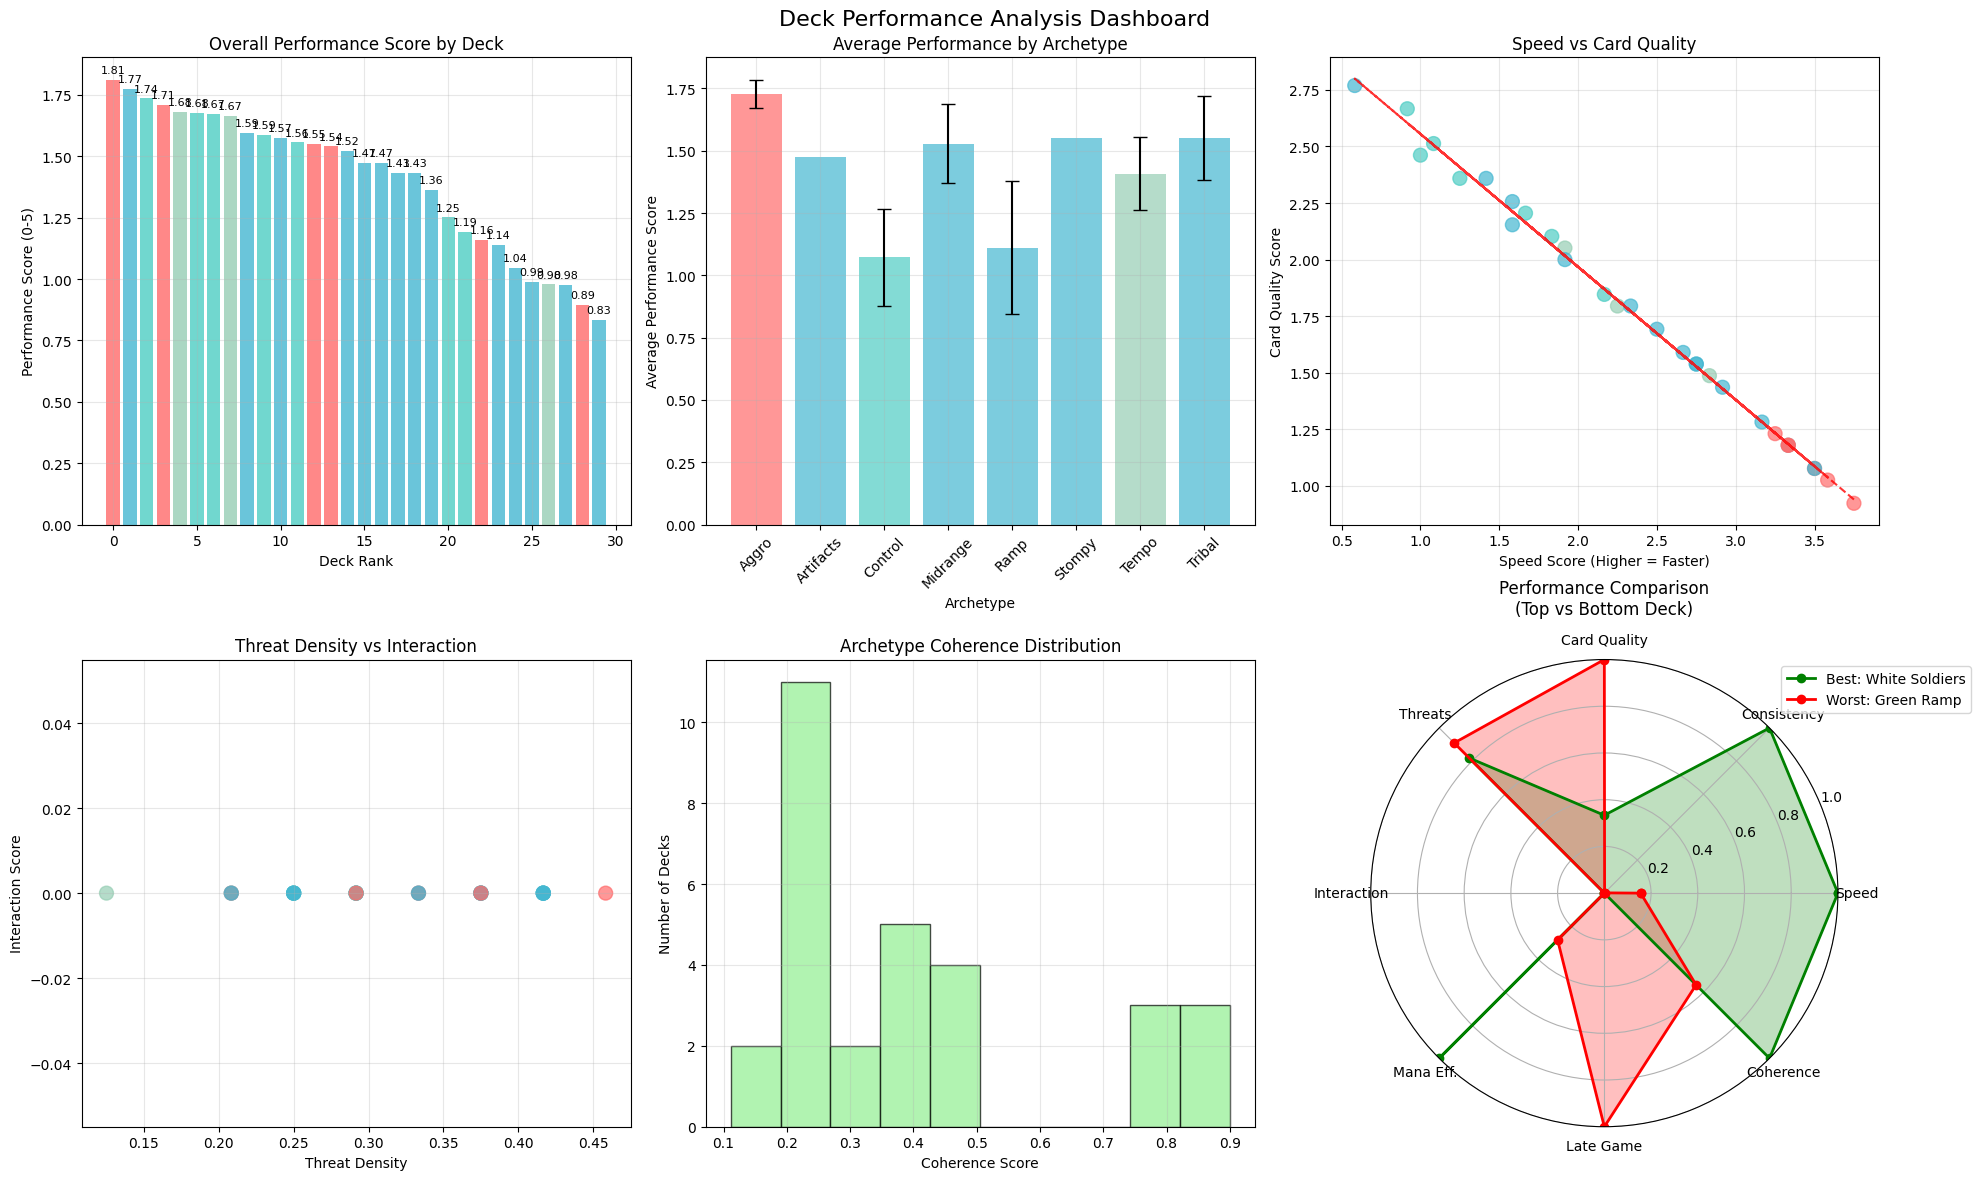

📊 Performance dashboard complete!
Best performing deck: White Soldiers (Score: 1.813)
Worst performing deck: Green Ramp (Score: 0.832)


In [17]:
# Create comprehensive performance visualizations
fig, axes = plt.subplots(2, 3, figsize=(20, 12))
fig.suptitle('Deck Performance Analysis Dashboard', fontsize=16, y=0.98)

# 1. Overall Performance Distribution
ax1 = axes[0, 0]
colors_by_archetype = [archetype_colors.get(arch, '#45B7D1') for arch in performance_df['archetype']]
bars = ax1.bar(range(len(performance_df)), performance_df['overall_performance'].sort_values(ascending=False),
               color=colors_by_archetype, alpha=0.8)
ax1.set_title('Overall Performance Score by Deck')
ax1.set_ylabel('Performance Score (0-5)')
ax1.set_xlabel('Deck Rank')
ax1.grid(True, alpha=0.3)

# Add value labels on bars
for i, (bar, score) in enumerate(zip(bars, performance_df['overall_performance'].sort_values(ascending=False))):
    ax1.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.02, 
             f'{score:.2f}', ha='center', va='bottom', fontsize=8)

# 2. Performance by Archetype
ax2 = axes[0, 1]
archetype_performance = performance_df.groupby('archetype')['overall_performance'].agg(['mean', 'std', 'count'])
bars2 = ax2.bar(archetype_performance.index, archetype_performance['mean'], 
                yerr=archetype_performance['std'], capsize=5, alpha=0.7,
                color=[archetype_colors.get(arch, '#45B7D1') for arch in archetype_performance.index])
ax2.set_title('Average Performance by Archetype')
ax2.set_ylabel('Average Performance Score')
ax2.set_xlabel('Archetype')
ax2.grid(True, alpha=0.3)
plt.setp(ax2.get_xticklabels(), rotation=45)

# 3. Speed vs Card Quality
ax3 = axes[0, 2]
scatter = ax3.scatter(performance_df['speed_score'], performance_df['card_quality'], 
                     c=colors_by_archetype, alpha=0.7, s=100)
ax3.set_title('Speed vs Card Quality')
ax3.set_xlabel('Speed Score (Higher = Faster)')
ax3.set_ylabel('Card Quality Score')
ax3.grid(True, alpha=0.3)

# Add trend line
z = np.polyfit(performance_df['speed_score'], performance_df['card_quality'], 1)
p = np.poly1d(z)
ax3.plot(performance_df['speed_score'], p(performance_df['speed_score']), "r--", alpha=0.8)

# 4. Threat Density vs Interaction
ax4 = axes[1, 0]
ax4.scatter(performance_df['threat_density'], performance_df['interaction_score'], 
           c=colors_by_archetype, alpha=0.7, s=100)
ax4.set_title('Threat Density vs Interaction')
ax4.set_xlabel('Threat Density')
ax4.set_ylabel('Interaction Score')
ax4.grid(True, alpha=0.3)

# 5. Archetype Coherence Distribution
ax5 = axes[1, 1]
ax5.hist(performance_df['archetype_coherence'], bins=10, alpha=0.7, color='lightgreen', edgecolor='black')
ax5.set_title('Archetype Coherence Distribution')
ax5.set_xlabel('Coherence Score')
ax5.set_ylabel('Number of Decks')
ax5.grid(True, alpha=0.3)

# 6. Performance Radar Chart (Top 5 vs Bottom 5)
ax6 = axes[1, 2]
ax6.remove()  # Remove this subplot for the radar chart

# Create radar chart
from math import pi
categories = ['Speed', 'Consistency', 'Card Quality', 'Threats', 'Interaction', 'Mana Eff.', 'Late Game', 'Coherence']
metric_cols = ['speed_score', 'consistency_score', 'card_quality', 'threat_density', 
               'interaction_score', 'mana_efficiency', 'late_game_power', 'archetype_coherence']

# Normalize metrics to 0-1 scale for radar chart
normalized_df = performance_df[metric_cols].copy()
for col in metric_cols:
    max_val = normalized_df[col].max()
    if max_val > 0:
        normalized_df[col] = normalized_df[col] / max_val

# Get top and bottom performers
top_deck = performance_df.nlargest(1, 'overall_performance').index[0]
bottom_deck = performance_df.nsmallest(1, 'overall_performance').index[0]

# Create subplot for radar
ax6 = plt.subplot(2, 3, 6, projection='polar')
angles = [n / float(len(categories)) * 2 * pi for n in range(len(categories))]
angles += angles[:1]

# Plot top performer
top_values = normalized_df.loc[top_deck, metric_cols].values.tolist()
top_values += top_values[:1]
ax6.plot(angles, top_values, 'o-', linewidth=2, label=f'Best: {top_deck}', color='green')
ax6.fill(angles, top_values, alpha=0.25, color='green')

# Plot bottom performer
bottom_values = normalized_df.loc[bottom_deck, metric_cols].values.tolist()
bottom_values += bottom_values[:1]
ax6.plot(angles, bottom_values, 'o-', linewidth=2, label=f'Worst: {bottom_deck}', color='red')
ax6.fill(angles, bottom_values, alpha=0.25, color='red')

ax6.set_xticks(angles[:-1])
ax6.set_xticklabels(categories)
ax6.set_ylim(0, 1)
ax6.set_title('Performance Comparison\n(Top vs Bottom Deck)', y=1.08)
ax6.legend(loc='upper right', bbox_to_anchor=(1.3, 1.0))

plt.tight_layout()
plt.show()

print("📊 Performance dashboard complete!")
print(f"Best performing deck: {top_deck} (Score: {performance_df.loc[top_deck, 'overall_performance']:.3f})")
print(f"Worst performing deck: {bottom_deck} (Score: {performance_df.loc[bottom_deck, 'overall_performance']:.3f})")

In [18]:
# Detailed Performance Analysis and Rankings
print("🏆 DETAILED PERFORMANCE RANKINGS")
print("="*60)

# Sort by overall performance
ranked_df = performance_df.sort_values('overall_performance', ascending=False)

print("TOP 10 PERFORMING DECKS:")
print("-" * 40)
for i, (theme, row) in enumerate(ranked_df.head(10).iterrows(), 1):
    print(f"{i:2d}. {theme:<20} ({row['archetype']:<8}) - Score: {row['overall_performance']:.3f}")

print("\nBOTTOM 5 PERFORMING DECKS:")
print("-" * 40)
for i, (theme, row) in enumerate(ranked_df.tail(5).iterrows(), len(ranked_df)-4):
    print(f"{i:2d}. {theme:<20} ({row['archetype']:<8}) - Score: {row['overall_performance']:.3f}")

# Category leaders
print("\n🥇 CATEGORY LEADERS:")
print("-" * 40)
categories = {
    'Fastest Deck': 'speed_score',
    'Most Consistent': 'consistency_score', 
    'Highest Card Quality': 'card_quality',
    'Best Threat Density': 'threat_density',
    'Most Interactive': 'interaction_score',
    'Most Mana Efficient': 'mana_efficiency',
    'Best Late Game': 'late_game_power',
    'Most Coherent': 'archetype_coherence'
}

for category, metric in categories.items():
    leader = performance_df.nlargest(1, metric)
    theme = leader.index[0]
    score = leader[metric].iloc[0]
    archetype = leader['archetype'].iloc[0]
    print(f"{category:<20}: {theme} ({archetype}) - {score:.3f}")

print("\n📊 PERFORMANCE STATISTICS:")
print("-" * 40)
print(f"Average Performance Score: {performance_df['overall_performance'].mean():.3f}")
print(f"Performance Std Deviation: {performance_df['overall_performance'].std():.3f}")
print(f"Performance Range: {performance_df['overall_performance'].min():.3f} - {performance_df['overall_performance'].max():.3f}")

# Archetype analysis
print(f"\n🎯 ARCHETYPE PERFORMANCE:")
print("-" * 40)
archetype_stats = performance_df.groupby('archetype')['overall_performance'].agg(['mean', 'std', 'count'])
for archetype, stats in archetype_stats.iterrows():
    print(f"{archetype:<12}: Avg {stats['mean']:.3f} ± {stats['std']:.3f} ({stats['count']} decks)")

# Balance assessment
performance_range = performance_df['overall_performance'].max() - performance_df['overall_performance'].min()
print(f"\n⚖️ BALANCE ASSESSMENT:")
print("-" * 40)
if performance_range < 1.0:
    print("✅ EXCELLENT balance - decks are very evenly matched")
elif performance_range < 1.5:
    print("✅ GOOD balance - reasonable variation between decks")
elif performance_range < 2.0:
    print("⚠️  MODERATE balance - some decks significantly stronger")
else:
    print("❌ POOR balance - large performance gaps between decks")

print(f"Performance range: {performance_range:.3f}")
print(f"Coefficient of variation: {(performance_df['overall_performance'].std() / performance_df['overall_performance'].mean()):.3f}")

🏆 DETAILED PERFORMANCE RANKINGS
TOP 10 PERFORMING DECKS:
----------------------------------------
 1. White Soldiers       (Aggro   ) - Score: 1.813
 2. White Vanguard       (Aggro   ) - Score: 1.773
 3. Rakdos Aggro         (Aggro   ) - Score: 1.736
 4. Red Goblins          (Aggro   ) - Score: 1.710
 5. Red Burn             (Aggro   ) - Score: 1.681
 6. Black Sacrifice      (Midrange) - Score: 1.677
 7. Green Elves          (Tribal  ) - Score: 1.671
 8. Boros Aggro          (Aggro   ) - Score: 1.665
 9. White Equipment      (Midrange) - Score: 1.595
10. Orzhov Lifegain Value (Midrange) - Score: 1.589

BOTTOM 5 PERFORMING DECKS:
----------------------------------------
26. Black Graveyard      (Control ) - Score: 0.987
27. Blue Wizards         (Control ) - Score: 0.978
28. Dimir Mill           (Control ) - Score: 0.976
29. Blue Card Draw       (Control ) - Score: 0.893
30. Green Ramp           (Ramp    ) - Score: 0.832

🥇 CATEGORY LEADERS:
----------------------------------------
Faste

In [19]:
def generate_improvement_suggestions(deck_name, metrics, deck_df):
    """Generate specific improvement suggestions for a deck based on its metrics."""
    suggestions = []
    
    # Speed improvements
    if metrics['speed_score'] < 2.5:
        avg_cmc = deck_df[deck_df['Type'].str.contains('Land', na=False) == False]['CMC'].mean()
        suggestions.append(f"⚡ SPEED: Reduce average CMC from {avg_cmc:.1f} - add more 1-2 mana cards")
    
    # Consistency improvements  
    if metrics['consistency_score'] < 2.5:
        suggestions.append("🎯 CONSISTENCY: High CMC variance - smooth out the mana curve")
    
    # Card quality improvements
    if metrics['card_quality'] < 2.0:
        suggestions.append("⭐ QUALITY: Replace weakest cards with higher impact alternatives")
    
    # Threat density improvements
    if metrics['threat_density'] < 0.3:
        suggestions.append("👊 THREATS: Add more win conditions - need creatures with 3+ power or other threats")
    
    # Interaction improvements
    if metrics['interaction_score'] < 0.15:
        suggestions.append("🛡️ INTERACTION: Add removal spells, counterspells, or other answers")
    
    # Mana efficiency improvements
    if metrics['mana_efficiency'] < 1.0:
        suggestions.append("💎 EFFICIENCY: Cards are expensive for their effects - need better mana-to-impact ratio")
    
    # Late game improvements
    if metrics['late_game_power'] < 0.1 and metrics['archetype_coherence'] > 0.7:
        archetype = ALL_THEMES.get(deck_name, {}).get('archetype', 'Midrange')
        if archetype in ['Control', 'Midrange']:
            suggestions.append("🏰 LATE GAME: Add more expensive, powerful finishers")
    
    # Archetype coherence improvements
    if metrics['archetype_coherence'] < 0.5:
        archetype = ALL_THEMES.get(deck_name, {}).get('archetype', 'Midrange')
        if archetype == 'Aggro':
            suggestions.append("🏃 FOCUS: Deck should be faster and more aggressive for aggro archetype")
        elif archetype == 'Control':
            suggestions.append("🧠 FOCUS: Need more interaction and late-game power for control archetype")
        elif archetype == 'Combo':
            suggestions.append("⚙️ FOCUS: Improve consistency and mana efficiency for combo archetype")
        else:
            suggestions.append("🎯 FOCUS: Better align cards with the midrange/tempo strategy")
    
    return suggestions

# Analyze weakest performing decks and generate improvement suggestions
print("🔧 IMPROVEMENT SUGGESTIONS FOR WEAKEST DECKS")
print("="*60)

weakest_decks = ranked_df.tail(5)
for deck_name, metrics in weakest_decks.iterrows():
    print(f"\n📋 {deck_name.upper()} ({metrics['archetype']})")
    print(f"Current Score: {metrics['overall_performance']:.3f}")
    print("-" * 40)
    
    suggestions = generate_improvement_suggestions(deck_name, metrics, deck_dataframes[deck_name])
    
    if suggestions:
        for suggestion in suggestions:
            print(f"  {suggestion}")
    else:
        print("  ✅ Deck is performing well overall - minor tweaks may help")
    
    # Show current deck composition for context
    deck_df = deck_dataframes[deck_name]
    non_lands = deck_df[deck_df['Type'].str.contains('Land', na=False) == False]
    creatures = deck_df[deck_df['Type'].str.contains('Creature', na=False)]
    
    print(f"  📊 Current Stats:")
    print(f"     - Avg CMC: {non_lands['CMC'].mean():.1f}")
    print(f"     - Creatures: {len(creatures)}/{len(non_lands)}")
    print(f"     - Early game (CMC ≤2): {len(non_lands[non_lands['CMC'] <= 2])}")

print(f"\n💡 GENERAL IMPROVEMENT STRATEGIES:")
print("-" * 40)
print("1. 🎯 Focus on archetype coherence - ensure cards support the deck's strategy")
print("2. ⚡ Balance mana curve - avoid too many expensive or cheap cards")
print("3. 👊 Include enough threats - minimum 30-40% of non-lands should pressure opponents") 
print("4. 🛡️ Add interaction - 15-25% removal/answers help deal with opposing threats")
print("5. ⭐ Prioritize card quality - powerful effects are worth slightly higher mana costs")
print("6. 🔄 Test synergies - cards that work together are more than sum of parts")

🔧 IMPROVEMENT SUGGESTIONS FOR WEAKEST DECKS

📋 BLACK GRAVEYARD (Control)
Current Score: 0.987
----------------------------------------
  ⚡ SPEED: Reduce average CMC from 3.9 - add more 1-2 mana cards
  🎯 CONSISTENCY: High CMC variance - smooth out the mana curve
  🛡️ INTERACTION: Add removal spells, counterspells, or other answers
  💎 EFFICIENCY: Cards are expensive for their effects - need better mana-to-impact ratio
  🧠 FOCUS: Need more interaction and late-game power for control archetype
  📊 Current Stats:
     - Avg CMC: 3.9
     - Creatures: 9/12
     - Early game (CMC ≤2): 3

📋 BLUE WIZARDS (Control)
Current Score: 0.978
----------------------------------------
  ⚡ SPEED: Reduce average CMC from 4.0 - add more 1-2 mana cards
  🎯 CONSISTENCY: High CMC variance - smooth out the mana curve
  👊 THREATS: Add more win conditions - need creatures with 3+ power or other threats
  🛡️ INTERACTION: Add removal spells, counterspells, or other answers
  💎 EFFICIENCY: Cards are expensive for 

In [20]:
# Export performance analysis results
performance_export = performance_df.round(3)
performance_export.to_csv('output/deck_performance_analysis.csv')

# Create a summary report
summary_report = {
    'total_decks': len(performance_df),
    'avg_performance': performance_df['overall_performance'].mean(),
    'performance_std': performance_df['overall_performance'].std(),
    'best_deck': performance_df.nlargest(1, 'overall_performance').index[0],
    'worst_deck': performance_df.nsmallest(1, 'overall_performance').index[0],
    'most_balanced_archetype': archetype_stats.loc[archetype_stats['std'].idxmin()].name,
    'performance_range': performance_df['overall_performance'].max() - performance_df['overall_performance'].min()
}

print("📄 PERFORMANCE ANALYSIS EXPORT COMPLETE")
print("="*50)
print(f"✅ Detailed metrics saved to: deck_performance_analysis.csv")
print(f"✅ Analysis covers {summary_report['total_decks']} decks")
print(f"✅ Performance range: {summary_report['performance_range']:.3f}")
print(f"✅ Best deck: {summary_report['best_deck']}")
print(f"✅ Most balanced archetype: {summary_report['most_balanced_archetype']}")

# Show exportable data preview
print(f"\n📊 EXPORTABLE PERFORMANCE DATA PREVIEW:")
print("-" * 50)
preview_cols = ['archetype', 'overall_performance', 'speed_score', 'card_quality', 'threat_density', 'interaction_score']
print(performance_export[preview_cols].head(10))

📄 PERFORMANCE ANALYSIS EXPORT COMPLETE
✅ Detailed metrics saved to: deck_performance_analysis.csv
✅ Analysis covers 30 decks
✅ Performance range: 0.981
✅ Best deck: White Soldiers
✅ Most balanced archetype: Aggro

📊 EXPORTABLE PERFORMANCE DATA PREVIEW:
--------------------------------------------------
                archetype  overall_performance  speed_score  card_quality  \
theme                                                                       
White Soldiers      Aggro                1.813        3.750         0.923   
White Equipment  Midrange                1.595        2.917         1.436   
White Angels      Control                1.473        0.917         2.667   
White Vanguard      Aggro                1.773        3.500         1.077   
Blue Flying         Tempo                1.433        1.917         2.051   
Blue Wizards      Control                0.978        1.000         2.462   
Blue Card Draw    Control                0.893        1.250         2.359   
Blu

In [21]:
# Load the complete MTG card database for validation
import re
from collections import Counter, defaultdict
from jumpstart.src.theme_extraction.keywords import ALL_KEYWORD_SETS

print("🔄 Loading complete MTG card database...")
cards_df = pd.read_csv('.build/cards.csv')
print(f"✅ Loaded {len(cards_df)} cards for validation")

# Clean and prepare card data for analysis
cards_df['text'] = cards_df['text'].fillna('')  # Handle missing text
cards_df['text_lower'] = cards_df['text'].str.lower()
cards_df['type_lower'] = cards_df['type'].str.lower() 

print(f"Sample card data:")
print(f"  Total cards: {len(cards_df)}")
print(f"  Cards with text: {len(cards_df[cards_df['text'] != ''])}")
print(f"  Unique card types: {cards_df['type'].nunique()}")

# Show some examples
print(f"\nExample cards:")
sample_cards = cards_df[cards_df['text'] != ''].head(3)
for _, card in sample_cards.iterrows():
    print(f"  {card['name']}: {card['text'][:100]}...")

🔄 Loading complete MTG card database...
✅ Loaded 32383 cards for validation
Sample card data:
  Total cards: 32383
  Cards with text: 32037
  Unique card types: 3650

Example cards:
  And They Shall Know No Fear: Choose a creature type. Creatures you control of the chosen type get +1/+0 and gain indestructible u...
  Celestine, the Living Saint: Flying, lifelink\nHealing Tears — At the beginning of your end step, return target creature card wit...
  Defenders of Humanity: When this enchantment enters, create X 2/2 white Astartes Warrior creature tokens with vigilance.\n{...
